In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [34]:
df = pd.read_csv('/content/train.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


In [35]:
train_df = df.head(37800)
val_df = df.tail(4200)

train_labels = train_df.pop('label')
val_labels = val_df.pop('label')

In [36]:
tf_train_df = tf.data.Dataset.from_tensor_slices((train_df.values, train_labels.values))
tf_val_df = tf.data.Dataset.from_tensor_slices((val_df.values, val_labels.values))

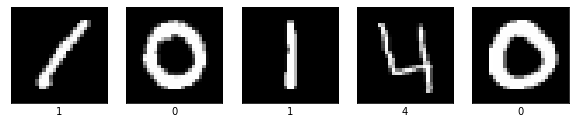

In [37]:
plt.figure(figsize=(10,10))
i = 0
for image, label in tf_train_df.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())
    i = i + 1

In [38]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32) / 255.   
    return image,label
tf_train_df = tf_train_df.map(preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_val_df = tf_val_df.map(preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(tf_train_df)
print(tf_val_df)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [39]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)
    tf_data = tf_data.batch(32)
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return tf_data

tf_train_df = pipeline(tf_train_df)
tf_val_df = pipeline(tf_val_df)

print(tf_train_df)
print(tf_val_df)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [40]:
model = tf.keras.Sequential([tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),tf.keras.layers.MaxPooling2D((2, 2)),tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),tf.keras.layers.MaxPooling2D((2, 2)),tf.keras.layers.Flatten(),tf.keras.layers.Dense(120, activation='relu'),tf.keras.layers.Dense(84, activation='relu'),tf.keras.layers.Dense(10, activation='softmax'),])


In [41]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [42]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [43]:
train_log = model.fit(tf_train_df,validation_data=tf_val_df,epochs=30,callbacks=callbacks)

Epoch 1/30
1182/1182 [==============================] - 33s 27ms/step - loss: 0.2376 - accuracy: 0.9281 - val_loss: 0.1110 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/30
1182/1182 [==============================] - 30s 25ms/step - loss: 0.0722 - accuracy: 0.9779 - val_loss: 0.0778 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 3/30
1182/1182 [==============================] - 32s 27ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.0742 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 4/30
1182/1182 [==============================] - 31s 26ms/step - loss: 0.0390 - accuracy: 0.9881 - val_loss: 0.0543 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 5/30
1182/1182 [==============================] - 30s 25ms/step - loss: 0.0319 - accuracy: 0.9902 - val_loss: 0.0663 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 6/30
1182/1182 [==============================] - 30s 25ms/step - loss: 0.0273 - accuracy: 0.9914 - val_loss: 0.0766 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 7/30
1182/1182 [========================

In [44]:
test_data =pd.read_csv('/content/test.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

In [45]:
predictions = model.predict(tf_test_data)
predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 2s 2s/step


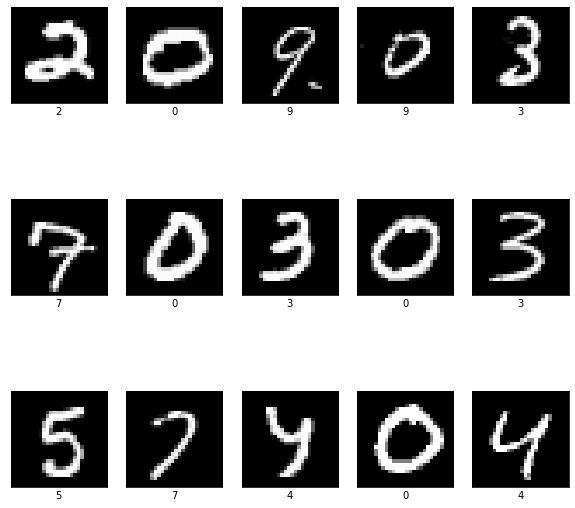

In [48]:
plt.figure(figsize=(10,10))

for i, row in test_data.head(15).iterrows():
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])